# Data Loading and EDA

-Loading the required libraries

-Loading patients and csv/xls datasets

-Preprocessing and some EDA on those datasets

-Defining functions to load images from patient folder

-Defining Hounsfield Unit funtion

-Doing some EDA for patient 0001

-Defining 3D plotting function (uses HU scale)

-Plotting interesting 3D graphs from patient 0001

### -Loading the required libraries

In [1]:
## Imports

import os
import pandas as pd
import pydicom
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pylidc as pl
from IPython.display import clear_output
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Importing our own functions

from functions import load_scan, get_pixels_hu, plot_3d_v2

### -Loading Patients and CSV/XLS Datasets

In [2]:
data_dir = "D:/DATASET LIDC-IDRI/manifest-1600709154662/LIDC-IDRI/"  #tem de ter / no final
metadata_file = "D:/DATASET LIDC-IDRI/datafiles/LIDC-IDRI_MetaData.csv"
nodule_count = "D:/DATASET LIDC-IDRI/datafiles/lidc-idri nodule counts (6-23-2015).xlsx"
diag_data = "D:/DATASET LIDC-IDRI/datafiles/tcia-diagnosis-data-2012-04-20.xls"

### Here, the patient data is loaded by retrieving a list of patient directories from the specified data_dir. The list is sorted and organized for further analysis.

In [3]:
patients = os.listdir(data_dir)
patients.sort()
print("Number of patients = ", len(patients))
#print(patients)

Number of patients =  1010


### The metadata, nodule count, and diagnosis datasets are loaded into Pandas DataFrames. These datasets provide valuable information about the patients, nodules, and their characteristics.



In [4]:
## Load Data

meta = pd.read_csv(metadata_file)
nodcds = pd.read_excel(nodule_count)
diagds = pd.read_excel(diag_data)

### -Data Cleaning, Processing and Exploration

In [5]:
## Remove useless info from metadata

meta = meta.drop(['Study Date','Series Description','File Size (Bytes)','Collection Name','Manufacturer','Study Description','Series ID'],axis=1)
meta.head(5)

,Subject ID,Study UID,Number of images,Modality
0,LIDC-IDRI-1001,1.3.6.1.4.1.14519.5.2.1.6279.6001.281499745765...,194,CT
1,LIDC-IDRI-0778,1.3.6.1.4.1.14519.5.2.1.6279.6001.174809695196...,481,CT
2,LIDC-IDRI-0813,1.3.6.1.4.1.14519.5.2.1.6279.6001.139110171863...,157,CT
3,LIDC-IDRI-0710,1.3.6.1.4.1.14519.5.2.1.6279.6001.116146223752...,471,CT
4,LIDC-IDRI-0410,1.3.6.1.4.1.14519.5.2.1.6279.6001.818775038273...,126,CT


In [6]:
## Remove useless info from nodule count dataset

nodcds = nodcds.drop(['Unnamed: 4','Unnamed: 5'],axis=1)
nodcds.head(5)

,TCIA Patent ID,Total Number of Nodules,Number of Nodules >=3mm,Number of Nodules <3mm
0,LIDC-IDRI-0001,4,1,3
1,LIDC-IDRI-0002,12,1,11
2,LIDC-IDRI-0003,4,4,0
3,LIDC-IDRI-0004,4,1,3
4,LIDC-IDRI-0005,9,3,6


In [7]:
## Merge datasets

dataset = pd.merge(nodcds, meta, left_on='TCIA Patent ID', right_on='Subject ID', how='inner')
dataset = dataset.drop(['Subject ID'],axis=1)
dataset.head(5)

,TCIA Patent ID,Total Number of Nodules,Number of Nodules >=3mm,Number of Nodules <3mm,Study UID,Number of images,Modality
0,LIDC-IDRI-0001,4,1,3,1.3.6.1.4.1.14519.5.2.1.6279.6001.175012972118...,2,DX
1,LIDC-IDRI-0001,4,1,3,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,133,CT
2,LIDC-IDRI-0002,12,1,11,1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801...,1,DX
3,LIDC-IDRI-0002,12,1,11,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,261,CT
4,LIDC-IDRI-0003,4,4,0,1.3.6.1.4.1.14519.5.2.1.6279.6001.202063331127...,5,DX


### Now we have a more organized dataset with the important information we need

### -Ploting some interesting features of this dataset

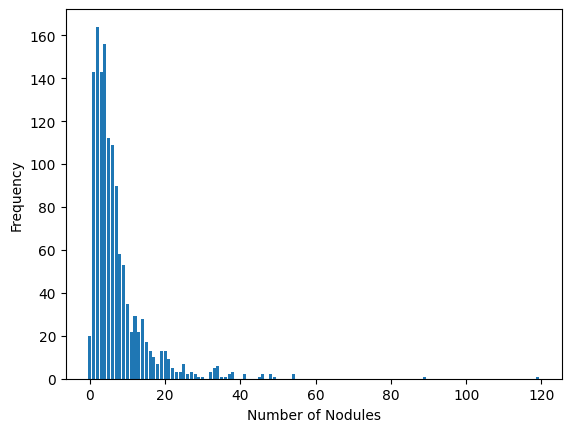

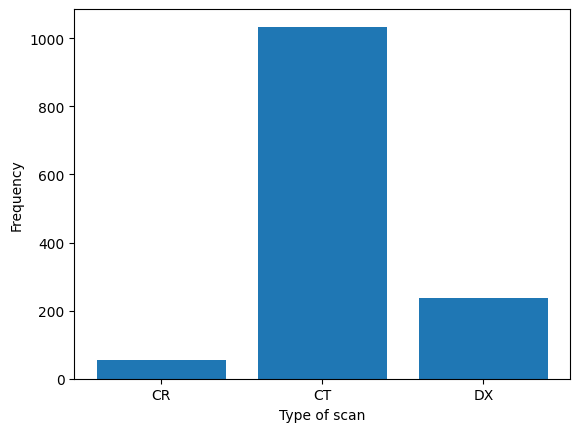

In [8]:
nodules = dataset['Total Number of Nodules'].value_counts().sort_index()
plt.bar(nodules.index, nodules.values)
plt.xlabel('Number of Nodules')
plt.ylabel('Frequency')
plt.show()

modal = dataset['Modality'].value_counts().sort_index()
plt.bar(modal.index, modal.values)
plt.xlabel('Type of scan')
plt.ylabel('Frequency')
plt.show()

### -Filter rows where 'Modality' is not 'CT' and drop them (not needed)


In [9]:
dataset = dataset[dataset['Modality'] == 'CT']
dataset.reset_index(drop=True, inplace=True)

### -Load DICOM Images (Only CT) and Define Hounsfield Unit Function
#### (On the functions.py file)

### -Hounsfield Units (HU) of a Patient
### Patient 0001 CT scans are loaded, and pixel values are converted to Hounsfield Units (HU)

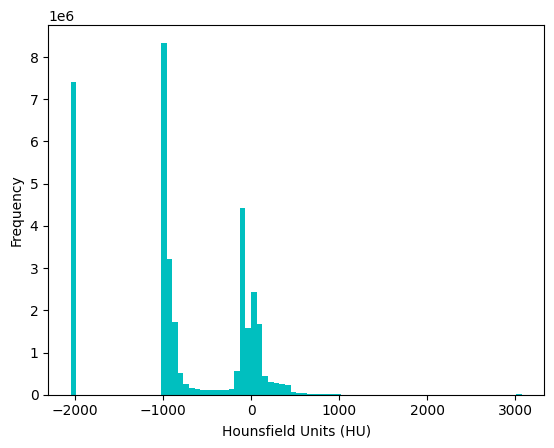

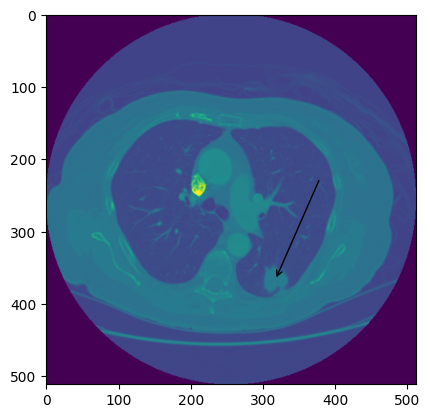

In [10]:
## HU of a patient

first_patient = load_scan(data_dir + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show slice with nodule (Patient 0001)
plt.imshow(first_patient_pixels[90])
plt.annotate('', xy=(317, 367), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
plt.show()

### -Show all slices of the patient 

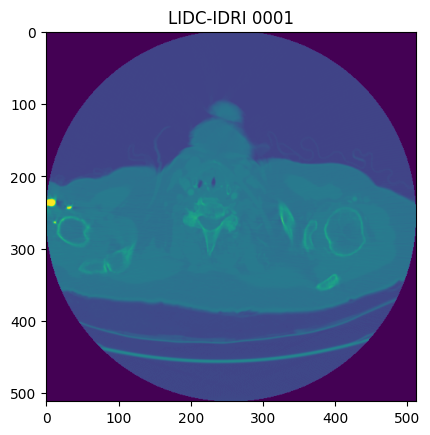

In [11]:
## Show CT scans of the patient

for sl in first_patient:
    plt.imshow(sl.pixel_array)
    plt.title("LIDC-IDRI 0001")
    plt.show()
    clear_output(wait=True)

### -Plot interesting 3d graph
### Using HU we can plot any structure in the scan

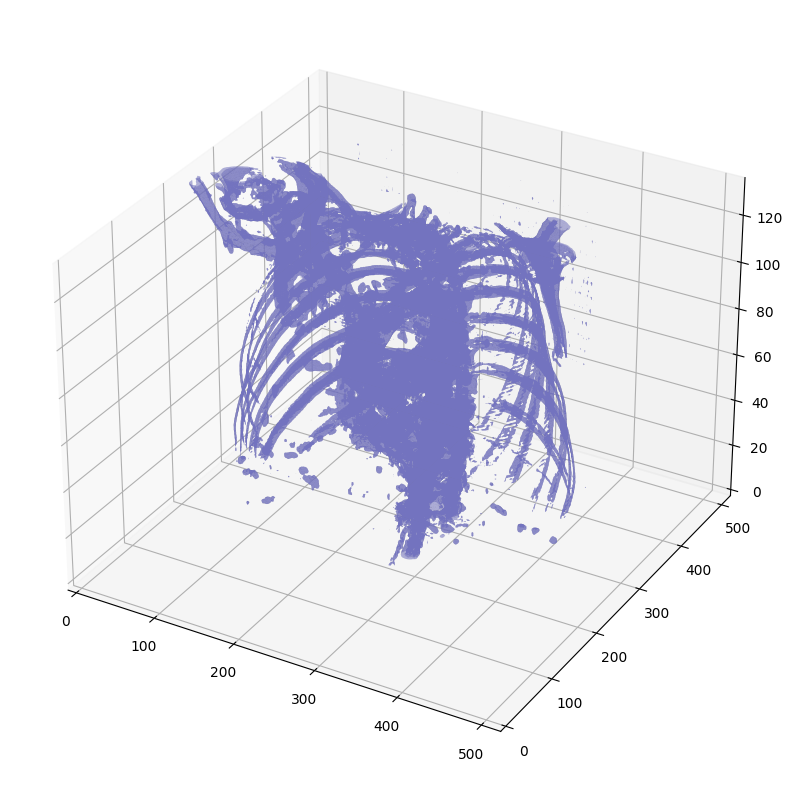

In [12]:
## 3D plotting only the bones (HU =~400)

plot_3d_v2(first_patient_pixels, 400)